In [1]:
import sys
sys.path.append('../astro_tools')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import wcs
import cmasher as cmr
from matplotlib.offsetbox import AnchoredText
import scipy.ndimage

import axes_offset

In [2]:
cube = fits.open('../ngc253/muse/data/ADP.2018-11-22T21_29_46.157.fits')
w = wcs.WCS(cube[1].header, naxis=2).celestial

which_model_infile = '../ngc253/muse/Nov28/BIC_PHYS_RATIO_1p5.fits'
hdu_BIC = fits.open(which_model_infile)
which_model = hdu_BIC[0].data
ra_hms, dec_dms = axes_offset.get_offset(which_model, w)
extent = axes_offset.get_extent(cube[1].data, x_dim=2, y_dim=1, pixscale=0.2)

<SkyCoord (ICRS): (ra, dec) in deg
    (11.89324135, -25.29320832)>


In [70]:
# fig, (ax) = plt.subplots(1, 1, figsize=(7, 7), sharex=True, sharey=True)
# cmap = cmr.get_sub_cmap('cmr.cosmic', 0.2, 0.7, N=2)

# im = ax.imshow(which_model, vmin=1, vmax=2, cmap=cmap, origin='lower', extent=extent)
# ax.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=16, length=5, color='black')
# ax.set_xticks([-40, -20, 0, 20, 40])
# ax.set_yticks([-40, -20, 0, 20, 40])
# ax.set_ylabel('Dec. Offset from %s (arcsec)' % dec_dms, fontsize=18)
# ax.set_xlabel('R.A. Offset from %s (arcsec)' % ra_hms, fontsize=18)

# # add a color bar
# cax = ax.inset_axes([1.04, 0.002, 0.05, 1])  # make another axis for the colorbar 
#                                              # [x0, y0, width, height] where x0, y0 = lower left corner
# bar = fig.colorbar(im, ax=ax, cax=cax)
# bar.set_label('Number of H$\\alpha$ Components', fontsize=18)
# bar.ax.tick_params(width=1, labelsize=16, length=7, direction='in')
# bar.ax.locator_params(nbins=2)

# plt.tight_layout()
# plt.subplots_adjust(wspace=-0.05, hspace=0)
# # plt.savefig('../ngc253/muse/visuals/which_model_total.png', bbox_inches='tight',dpi=200)
# # plt.savefig('../ngc253/muse/visuals/which_model_total.pdf', bbox_inches='tight',dpi=200)
# plt.show()

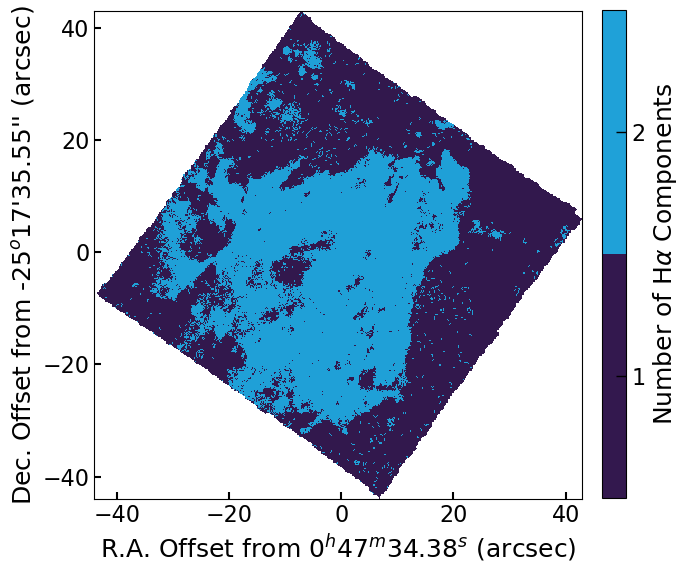

In [72]:
# this will filter things out
which_model_binary = np.copy(which_model)
which_model_binary[which_model_binary == 1.] = 0.
which_model_binary[(which_model_binary == 2.) | (which_model_binary == 3.)] = 1.

id_regions, num_ids = scipy.ndimage.label(which_model_binary.byteswap().newbyteorder('='), structure=np.ones((3,3)))
id_sizes = np.array(scipy.ndimage.sum(which_model_binary, id_regions, range(num_ids + 1)))
area_mask = (id_sizes == 1)
which_model_binary[area_mask[id_regions]] = 0

which_model_filtered = which_model_binary.copy()
which_model_filtered[which_model_binary == 1.] = 2.
which_model_filtered[which_model_binary == 0.] = 1.

fig, (ax) = plt.subplots(1, 1, figsize=(7, 7), sharex=True, sharey=True)
cmap = cmr.get_sub_cmap('cmr.cosmic', 0.2, 0.7, N=2)

im = ax.imshow(which_model_filtered, vmin=1, vmax=2, cmap=cmap, origin='lower', extent=extent)
ax.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=16, length=5, color='black')
ax.set_xticks([-40, -20, 0, 20, 40])
ax.set_yticks([-40, -20, 0, 20, 40])
ax.set_ylabel('Dec. Offset from %s (arcsec)' % dec_dms, fontsize=18)
ax.set_xlabel('R.A. Offset from %s (arcsec)' % ra_hms, fontsize=18)

# add a color bar
cax = ax.inset_axes([1.04, 0.002, 0.05, 1])  # make another axis for the colorbar 
                                             # [x0, y0, width, height] where x0, y0 = lower left corner
bar = fig.colorbar(im, ax=ax, cax=cax)
tick_locs = np.linspace(1, 2, 2 * 2 + 1)[1::2]
bar_tick_label = np.arange(1, 2 + 1)
bar.set_ticks(tick_locs)
bar.set_ticklabels(bar_tick_label)
bar.set_label('Number of H$\\alpha$ Components', fontsize=18)
bar.ax.tick_params(width=1, labelsize=16, length=7, direction='in')
bar.ax.locator_params(nbins=2)

plt.tight_layout()
plt.savefig('../ngc253/muse/visuals/Nov28_run/Davide/number_of_components.png', bbox_inches='tight',dpi=200)
plt.savefig('../ngc253/muse/visuals/Nov28_run/Davide/number_of_components.pdf', bbox_inches='tight',dpi=200)
plt.show()

hdul = fits.PrimaryHDU(data=which_model_filtered, header=cube[1].header)
hdul.writeto('../ngc253/muse/visuals/Nov28_run/Davide/ngc253_muse_components.fits',  overwrite=True)

In [3]:
def get_data(line,param,comp):
    
    """
    line must be ha, niia, niib, siia, or siib
    param must be amp, vel, or sigma
    comp must be outflow_blue, outflow_red, or disk
    
    """
    
    file = '../ngc253/muse/data/output_maps_old/ngc253_muse_se_%s_%s_%s.fits' % (line, param, comp)
    
    hdu = fits.open(file)
    hdu_data = hdu[0].data
    
    return(hdu_data)


def line_flux(amp, sig):
    
    """
    
    Adopted from https://lukeholden.com/blog/measuring_emission_line_fluxes_python.html#measuring_line_fluxes
    
    """
    
    sig_Ang = (sig * 2.2) / 100
    
    flux = amp * sig_Ang * np.sqrt(2*np.pi)
#     flux_err = flux*np.sqrt((peak_err/peak)**2 + (width_err/width)**2)
    return flux

ha_amp_outb = get_data(line='ha', param='amp', comp='outflow_blue')
ha_amp_outr = get_data(line='ha', param='amp', comp='outflow_red')
ha_amp_disk = get_data(line='ha', param='amp', comp='disk')

ha_sig_outb = get_data(line='ha', param='sig', comp='outflow_blue')
ha_sig_outr = get_data(line='ha', param='sig', comp='outflow_red')
ha_sig_disk = get_data(line='ha', param='sig', comp='disk')

ha_flux_disk = line_flux(ha_amp_disk, ha_sig_disk)  # calculate the area under the curve
ha_flux_outb = line_flux(ha_amp_outb, ha_sig_outb)
ha_flux_outr = line_flux(ha_amp_outr, ha_sig_outr)
ha_flux_disk[np.isnan(ha_flux_disk)] = 0  # deal with NaN s
ha_flux_outb[np.isnan(ha_flux_outb)] = 0
ha_flux_outr[np.isnan(ha_flux_outr)] = 0
# ha_flux_total = ha_flux_disk + ha_flux_outb + ha_flux_outr  # sum
ha_flux_total = ha_flux_outb #+ ha_flux_outr  # sum

ha_flux_outflow_region = np.full(ha_flux_total.shape, fill_value=np.nan)
ha_flux_outflow_region[which_model_filtered == 2.] = ha_flux_total[which_model_filtered == 2.]

ha_flux_outflow_region_units = ha_flux_outflow_region * 1.06  # units are 1.06 * 10^-11 W/m^2/sr

NameError: name 'which_model_filtered' is not defined

/var/folders/l6/c_b3rx3904g01kdj84qtknth0000gn/T/ipykernel_32981/129416592.py:4: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(ha_flux_outflow_region_units), cmap=cmap, vmin = 2,vmax = 5,origin='lower', extent=extent)


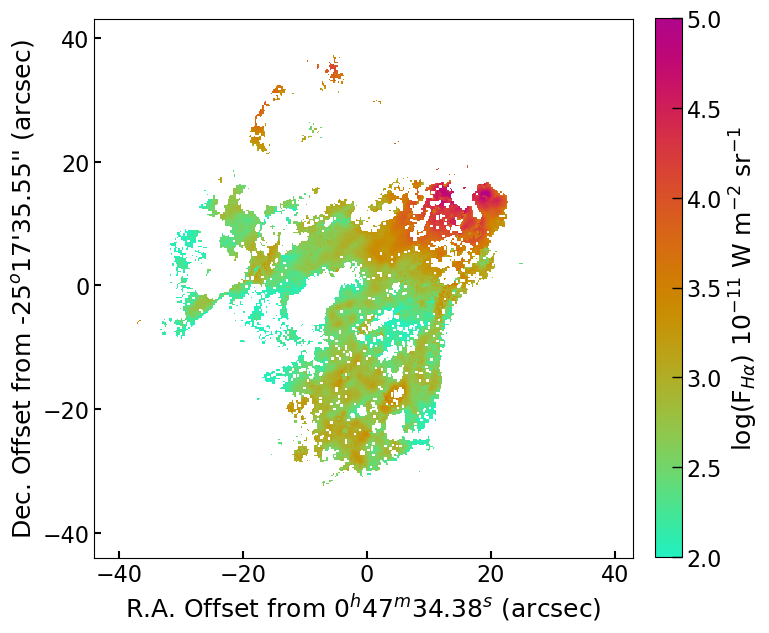

In [147]:
fig, (ax) = plt.subplots(1, 1, figsize=(7, 7), sharex=True, sharey=True)
cmap = cmr.get_sub_cmap('cmr.tropical_r', 0.1, 0.90)

im = ax.imshow(np.log10(ha_flux_outflow_region_units), cmap=cmap, vmin = 2,vmax = 5,origin='lower', extent=extent)
ax.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=16, length=5, color='black')
ax.set_xticks([-40, -20, 0, 20, 40])
ax.set_yticks([-40, -20, 0, 20, 40])
ax.set_ylabel('Dec. Offset from %s (arcsec)' % dec_dms, fontsize=18)
ax.set_xlabel('R.A. Offset from %s (arcsec)' % ra_hms, fontsize=18)

# add a color bar
cax = ax.inset_axes([1.04, 0.002, 0.05, 1])
bar = fig.colorbar(im, ax=ax, cax=cax)
bar.set_label('log(F$_{H\\alpha}$) $10^{-11}$ W m$^{-2}$ sr$^{-1}$', fontsize=18)
bar.ax.tick_params(width=1, labelsize=16, length=7, direction='in')

plt.savefig('../ngc253/muse/visuals/Nov28_run/Davide/ngc253_muse_halpha_outflow_integrated_intensity.png', bbox_inches='tight',dpi=200)
plt.savefig('../ngc253/muse/visuals/Nov28_run/Davide/ngc253_muse_halpha_outflow_integrated_intensity.pdf', bbox_inches='tight',dpi=200)
plt.show()

hdr = cube[1].header
hdr['BUNIT'] = '1.06*10**(-11) W/cm**2/sr'
hdul = fits.PrimaryHDU(data=ha_flux_outflow_region, header=cube[1].header)
hdul.writeto('../ngc253/muse/visuals/Nov28_run/Davide/ngc253_muse_halpha_outflow_integrated_intensity.fits', overwrite=True)

In [148]:
niia_amp_outb = get_data(line='niia', param='amp', comp='outflow_blue')
niia_amp_outr = get_data(line='niia', param='amp', comp='outflow_red')
niia_sig_outb = get_data(line='niia', param='sig', comp='outflow_blue')
niia_sig_outr = get_data(line='niia', param='sig', comp='outflow_red')

niib_amp_outb = get_data(line='niib', param='amp', comp='outflow_blue')
niib_amp_outr = get_data(line='niib', param='amp', comp='outflow_red')
niib_sig_outb = get_data(line='niib', param='sig', comp='outflow_blue')
niib_sig_outr = get_data(line='niib', param='sig', comp='outflow_red')

nii_flux_outb = line_flux(niia_amp_outb, niia_sig_outb) + line_flux(niib_amp_outb, niib_sig_outb)
nii_flux_outr = line_flux(niia_amp_outr, niia_sig_outr) + line_flux(niib_amp_outr, niib_sig_outr)
nii_flux_outb[np.isnan(nii_flux_outb)] = 0
nii_flux_outr[np.isnan(nii_flux_outr)] = 0
nii_flux_total = nii_flux_outb + nii_flux_outr

nii_flux_outflow_region = np.full(nii_flux_total.shape, fill_value=np.nan)
nii_flux_outflow_region[which_model_filtered == 2.] = nii_flux_total[which_model_filtered == 2.]
nii_flux_outflow_region_units = nii_flux_outflow_region * 1.06

/var/folders/l6/c_b3rx3904g01kdj84qtknth0000gn/T/ipykernel_32981/1548612149.py:4: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(nii_flux_outflow_region), cmap=cmap, vmin = 2.5,vmax = 5,origin='lower', extent=extent)


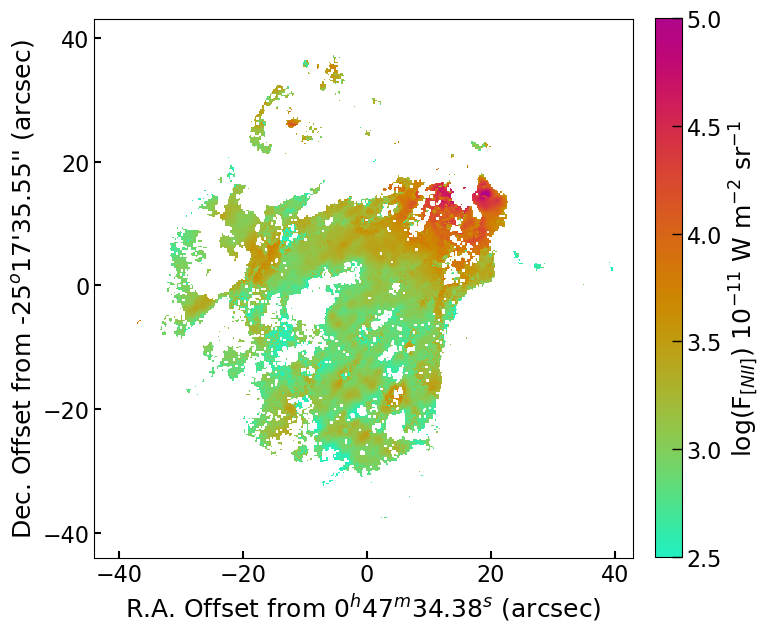

In [149]:
fig, (ax) = plt.subplots(1, 1, figsize=(7, 7), sharex=True, sharey=True)
cmap = cmr.get_sub_cmap('cmr.tropical_r', 0.1, 0.90)

im = ax.imshow(np.log10(nii_flux_outflow_region), cmap=cmap, vmin = 2.5,vmax = 5,origin='lower', extent=extent)
ax.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=16, length=5, color='black')
ax.set_xticks([-40, -20, 0, 20, 40])
ax.set_yticks([-40, -20, 0, 20, 40])
ax.set_ylabel('Dec. Offset from %s (arcsec)' % dec_dms, fontsize=18)
ax.set_xlabel('R.A. Offset from %s (arcsec)' % ra_hms, fontsize=18)

# add a color bar
cax = ax.inset_axes([1.04, 0.002, 0.05, 1])
bar = fig.colorbar(im, ax=ax, cax=cax)
bar.set_label('log(F$_{[N II]}$) $10^{-11}$ W m$^{-2}$ sr$^{-1}$', fontsize=18)
bar.ax.tick_params(width=1, labelsize=16, length=7, direction='in')

plt.savefig('../ngc253/muse/visuals/Nov28_run/Davide/ngc253_muse_nii_outflow_integrated_intensity.png', bbox_inches='tight',dpi=200)
plt.savefig('../ngc253/muse/visuals/Nov28_run/Davide/ngc253_muse_nii_outflow_integrated_intensity.pdf', bbox_inches='tight',dpi=200)
plt.show()

hdr = cube[1].header
hdr['BUNIT'] = '1.06*10**(-11) W/cm**2/sr'
hdul = fits.PrimaryHDU(data=nii_flux_outflow_region, header=hdr)
hdul.writeto('../ngc253/muse/visuals/Nov28_run/Davide/ngc253_muse_nii_outflow_integrated_intensity.fits', overwrite=True)

In [4]:
niia_amp_disk = get_data(line='niia', param='amp', comp='disk')
niia_amp_outb = get_data(line='niia', param='amp', comp='outflow_blue')
niia_amp_outr = get_data(line='niia', param='amp', comp='outflow_red')
niia_sig_disk = get_data(line='niia', param='sig', comp='disk')
niia_sig_outb = get_data(line='niia', param='sig', comp='outflow_blue')
niia_sig_outr = get_data(line='niia', param='sig', comp='outflow_red')

niib_amp_disk = get_data(line='niib', param='amp', comp='disk')
niib_amp_outb = get_data(line='niib', param='amp', comp='outflow_blue')
niib_amp_outr = get_data(line='niib', param='amp', comp='outflow_red')
niib_sig_disk = get_data(line='niib', param='sig', comp='disk')
niib_sig_outb = get_data(line='niib', param='sig', comp='outflow_blue')
niib_sig_outr = get_data(line='niib', param='sig', comp='outflow_red')

nii_flux_disk = line_flux(niia_amp_disk, niia_sig_disk) + line_flux(niib_amp_disk, niib_sig_disk)
nii_flux_outb = line_flux(niia_amp_outb, niia_sig_outb) + line_flux(niib_amp_outb, niib_sig_outb)
nii_flux_outr = line_flux(niia_amp_outr, niia_sig_outr) + line_flux(niib_amp_outr, niib_sig_outr)
nii_flux_outb[np.isnan(nii_flux_outb)] = 0
nii_flux_outr[np.isnan(nii_flux_outr)] = 0
nii_flux_total = nii_flux_outb + nii_flux_outr + nii_flux_disk

# nii_flux_outflow_region = np.full(nii_flux_total.shape, fill_value=np.nan)
# nii_flux_outflow_region[which_model_filtered == 2.] = nii_flux_total[which_model_filtered == 2.]
nii_flux_total_units = nii_flux_total * 1.06

/var/folders/l6/c_b3rx3904g01kdj84qtknth0000gn/T/ipykernel_57441/1912901027.py:4: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(nii_flux_total_units), cmap=cmap, vmin = 2.5,vmax = 5,origin='lower', extent=extent)


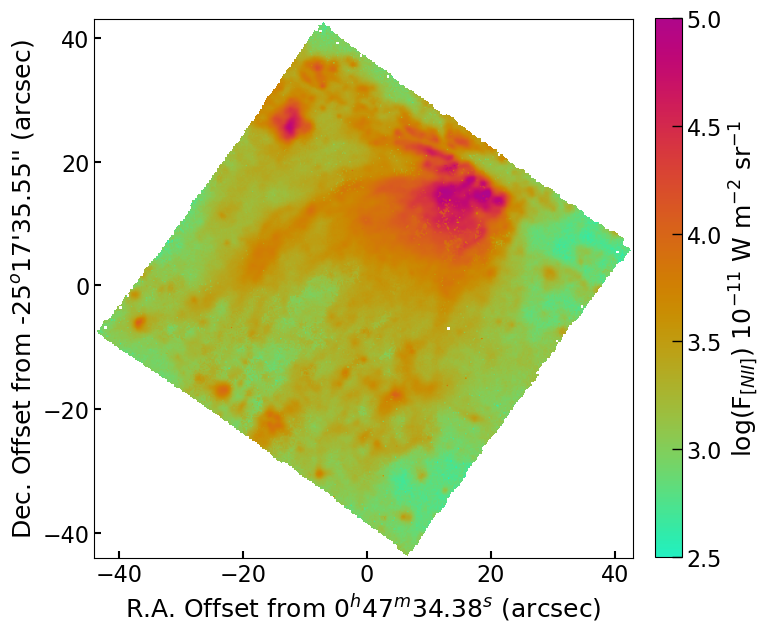

In [7]:
fig, (ax) = plt.subplots(1, 1, figsize=(7, 7), sharex=True, sharey=True)
cmap = cmr.get_sub_cmap('cmr.tropical_r', 0.1, 0.90)

im = ax.imshow(np.log10(nii_flux_total_units), cmap=cmap, vmin = 2.5,vmax = 5,origin='lower', extent=extent)
ax.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=16, length=5, color='black')
ax.set_xticks([-40, -20, 0, 20, 40])
ax.set_yticks([-40, -20, 0, 20, 40])
ax.set_ylabel('Dec. Offset from %s (arcsec)' % dec_dms, fontsize=18)
ax.set_xlabel('R.A. Offset from %s (arcsec)' % ra_hms, fontsize=18)

# add a color bar
cax = ax.inset_axes([1.04, 0.002, 0.05, 1])
bar = fig.colorbar(im, ax=ax, cax=cax)
bar.set_label('log(F$_{[N II]}$) $10^{-11}$ W m$^{-2}$ sr$^{-1}$', fontsize=18)
bar.ax.tick_params(width=1, labelsize=16, length=7, direction='in')

plt.savefig('../ngc253/muse/visuals/Nov28_run/Davide/ngc253_muse_nii_integrated_intensity_total.png', bbox_inches='tight',dpi=200)
plt.savefig('../ngc253/muse/visuals/Nov28_run/Davide/ngc253_muse_nii_integrated_intensity_total.pdf', bbox_inches='tight',dpi=200)
plt.show()

hdr = cube[1].header
hdr['BUNIT'] = '1.06*10**(-11) W/cm**2/sr'
hdul = fits.PrimaryHDU(data=nii_flux_total_units, header=hdr)
hdul.writeto('../ngc253/muse/visuals/Nov28_run/Davide/ngc253_muse_nii_integrated_intensity_total.fits', overwrite=True)